# Support Vector Machines
(Large margin classification)

SVM performs classification by finding the hyper-plane that differentiate the two classes very well.

The SMO algorithm gives an efficient way of solving the dual problem of the (regularized) Support Vector Machine optimization problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import scipy.io as sio

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from IPython.display import display, Markdown, Math
from pprint import pprint

%matplotlib inline

In [2]:
def plotSVM(X_train, y_train, X_test, y_test, theta, title):
    """ Scatter plot to show classification using SVM's hyperplane.
    
    highlights positive and negative classes in both training and test dataset.
    plots the decision boundary to classify the two classes.
    """
    
    # Dataframe with X and y concatenated
    test_df = pd.DataFrame(data=np.column_stack((X_test[:,1:],y_test)), columns=['X1','X2','Y'])
    train_df = pd.DataFrame(data=np.column_stack((X_train[:,1:],y_train)), columns=['X1','X2','Y'])

    # Segregation of Testing and Training data into + and - classes
    positive_test = test_df[test_df['Y'].isin([1])]  
    negative_test = test_df[test_df['Y'].isin([-1])]

    positive_train = train_df[train_df['Y'].isin([1])]  
    negative_train = train_df[train_df['Y'].isin([-1])]
    
    fig, ax = plt.subplots(figsize=(12,8))  

    w0 = theta.item(0)
    w1, w2 = theta.item(1), theta.item(2)

    x_hyperplane = np.arange(math.floor(train_df['X1'].min()), math.ceil(train_df['X1'].max()),0.1)
    y_hyperplane = (-w0-w1*x_hyperplane)/w2

    ax.scatter(positive_train['X1'], positive_train['X2'], s=50, marker='^', label='Train Positive', c='b')  
    ax.scatter(positive_test['X1'], positive_test['X2'], s=50, marker='^', label='Test Positive',
               facecolors='none', edgecolors='b')  
    
    ax.scatter(negative_train['X1'], negative_train['X2'], s=50, marker='o', label='Train Negative', c='r')  
    ax.scatter(negative_test['X1'], negative_test['X2'], s=50, marker='o', label='Test Negative', 
               facecolors='none', edgecolors='r')  
    
    plt.plot(x_hyperplane, y_hyperplane, 'k-', label='Decision Boundary')

    plt.legend(bbox_to_anchor=(1, 0), loc="upper right", ncol=5,
                bbox_transform=fig.transFigure, fontsize = 'medium', columnspacing = 0.5)  
    
    ax.set_xlabel('X1')  
    ax.set_ylabel('X2') 
    plt.title(title)
    fig.tight_layout()
    plt.show()

In [3]:
def predict(theta, X):  
    # signof(wx+b)
    y_predict = np.sign((X[:, 1:] * theta[:, 1:].T) + theta[:, 0])
    return y_predict

In [4]:
def classificationError(y_predict, y):
    """ returns the # of misclassifications and the error"""
    correct = [1 if a == b[0] else 0 for (a, b) in zip(y_predict, y.tolist())]  
    accuracy = (sum(map(int, correct)) / len(correct)*100)  
    misclassified = correct.count(0)
    err = misclassified/len(correct)
    
    return misclassified, err

In [5]:
def linear_classifier(alpha, y, K, i, b):
    temp = np.multiply(alpha, y)
    return temp.T * K[:, i] + b

In [6]:
def smo(X, y, K, c, tolerance, max_passes):
    """ runs the simplified SMO algorithm
    
    Input:
        x,y: training data
        K: Kernel matrix
        c: regularization parameter
        tolerance: numerical tolerance
        max_passes: max # of times to iterate over α’s without changing
    
    Output:
        alpha(α) ∈ Rm: Lagrange multipliers for solution
        b ∈ R : threshold for solution
    """
    
    # Initializations
    training_pts = X.shape[0]
    alpha = np.matrix(np.zeros((training_pts, 1)))
    b = 0
    passes = 0
    
    while(passes < max_passes):
        num_changes_alphas = 0
        
        for i in range(training_pts):
            y_i = y.item(i)
            alpha_i = alpha.item(i)
            # Calculate Ei
            E_i = linear_classifier(alpha, y, K, i, b) - y_i
            
            if ((y_i*E_i < -tolerance and alpha_i<c) or (y_i*E_i > tolerance and alpha_i>c)):
                # Select j != i randomly
                j = np.random.choice(np.arange(i).tolist() + np.arange(i, training_pts).tolist())
                y_j = y.item(j)
                alpha_j = alpha.item(j)
                
                # Calculate Ej
                E_j = linear_classifier(alpha, y, K, j, b) - y_j
                
                # Save old α’s
                alpha_i_old, alpha_j_old = alpha_i, alpha_j

                # Calculate L and H s.t. L ≤ αj ≤ H
                if (y_i != y_j):
                    L = max(0, alpha_j-alpha_i)
                    H = min(c, c+alpha_j-alpha_i)
                elif (y_i == y_j):
                    L = max(0, alpha_i+alpha_j-c)
                    H = min(c, alpha_i+alpha_j)

                if L==H:
                    continue

                n_para = 2 * K[i, j] - K[i, i] - K[j, j]
                
                if n_para >=0:
                    continue
                
                # Compute and clip new value for αj
                alpha_j = alpha_j - (y_j*(E_i - E_j)/n_para)
                alpha_j = H if (alpha_j > H) else (L if (alpha_j < L) else alpha_j)

                # Setting alpha[j] to the new value alpha_j
                alpha[j] = alpha_j
                
                if (abs(alpha_j - alpha_j_old) < math.pow(10,-5)):
                    continue

                # Determine value for αi
                alpha_i += y_i*y_j * (alpha_j_old - alpha_j)

                # Setting alpha[i] to the new value alpha_i
                alpha[i] = alpha_i
                
                # Compute b1 and b2
                b_1 = b - E_i - y_i*(alpha_i - alpha_i_old)*K[i, i] - y_j*(alpha_j - alpha_j_old)*K[i, j]
                b_2 = b - E_j - y_i*(alpha_i - alpha_i_old)*K[i, j] - y_j*(alpha_j - alpha_j_old)*K[j, j]

                b = b_1 if (alpha_i>0 and alpha_i<c) else(b_2 if (alpha_j>0 and alpha_j<c) else (b_1+b_2)/2)
                
                num_changes_alphas += 1

        if (num_changes_alphas == 0):
            passes += 1
        else:
            passes = 0
            
    return alpha,b

### Dataset 1

In [7]:
dataset1 = sio.loadmat('data1')

In [8]:
X1_train, y1_train = np.matrix(dataset1['X_trn']), np.matrix(dataset1['Y_trn'])
X1_test, y1_test = np.matrix(dataset1['X_tst']), np.matrix(dataset1['Y_tst'])

In [9]:
X1_train = np.hstack((np.ones((X1_train.shape[0], 1)), X1_train))
X1_test = np.hstack((np.ones((X1_test.shape[0], 1)), X1_test))

In [10]:
# Replacing class label 0 with -1
# Mapping y from {0, 1} to {-1, 1}
y1_train = np.where(y1_train==0, -1, 1)
y1_test = np.where(y1_test==0, -1, 1)

In [11]:
# Kernel Matrix
K1 = np.dot(X1_train, X1_train.T)

## 1.a) SMO

In [12]:
c = 1
tolerance = 0.0001
max_passes=1000

In [13]:
alpha, b = smo(X1_train, y1_train, K1, c, tolerance, max_passes)

In [14]:
alpha.shape, b

((136, 1), matrix([[0.63313677]]))

In [15]:
temp = np.matrix(np.multiply(alpha, y1_train))
theta_smo = np.dot(temp.T, X1_train)
theta_smo[0, 0] = b
theta_smo

matrix([[ 0.63313677,  1.41713553, -1.09812449]])

### Classification error on training and test dataset1

In [16]:
y_predict = predict(theta_smo, X1_train) 
misclassified, err = classificationError(y_predict, y1_train)
print('No of mis-classified Training data points: {0}'.format(misclassified))
print('Classification Error (Training - Dataset 1) = {0:.2f}'.format(err))

No of mis-classified Training data points: 0
Classification Error (Training - Dataset 1) = 0.00


In [17]:
y_predict = predict(theta_smo, X1_test) 
misclassified, err = classificationError(y_predict, y1_test)
print('No of mis-classified Test data points: {0}'.format(misclassified))
print('Classification Error (Test - Dataset 1) = {0:.2f}'.format(err))

No of mis-classified Test data points: 0
Classification Error (Test - Dataset 1) = 0.00


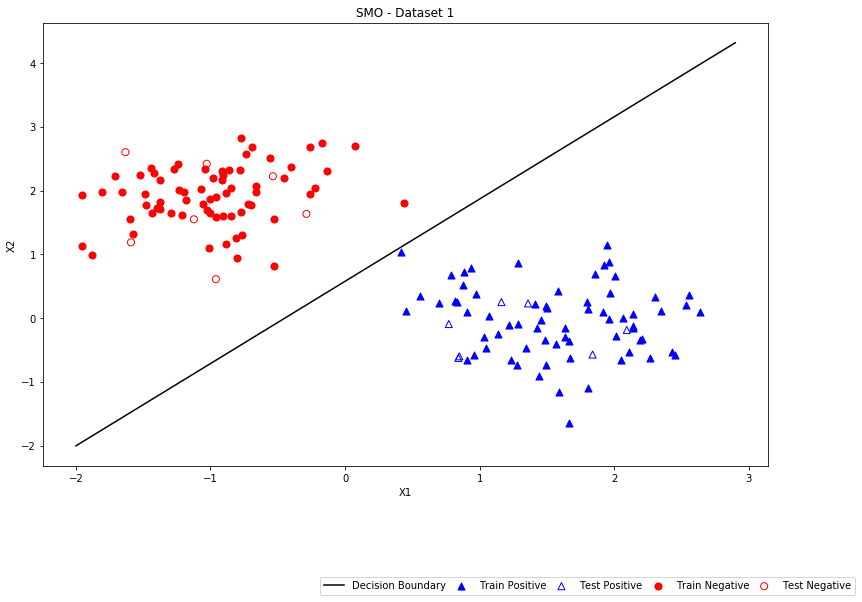

In [18]:
plotSVM(X1_train, y1_train, X1_test, y1_test, theta_smo, title = "SMO - Dataset 1")

## 1.b) Sklearn Linear SVC

In [19]:
clf = LinearSVC(random_state=0)
clf.fit(X1_train, np.ravel(y1_train))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [20]:
y_predict = predict(clf.coef_, X1_train) 
misclassified, err = classificationError(y_predict, y1_train)
print('No of mis-classified Training data points: {0}'.format(misclassified))
print('Classification Error (Training - Dataset 1) = {0:.2f}'.format(err))

No of mis-classified Training data points: 1
Classification Error (Training - Dataset 1) = 0.01


In [21]:
y_predict = predict(clf.coef_, X1_test) 
misclassified, err = classificationError(y_predict, y1_test)
print('No of mis-classified Test data points: {0}'.format(misclassified))
print('Classification Error (Test - Dataset 1) = {0:.2f}'.format(err))

No of mis-classified Test data points: 0
Classification Error (Test - Dataset 1) = 0.00


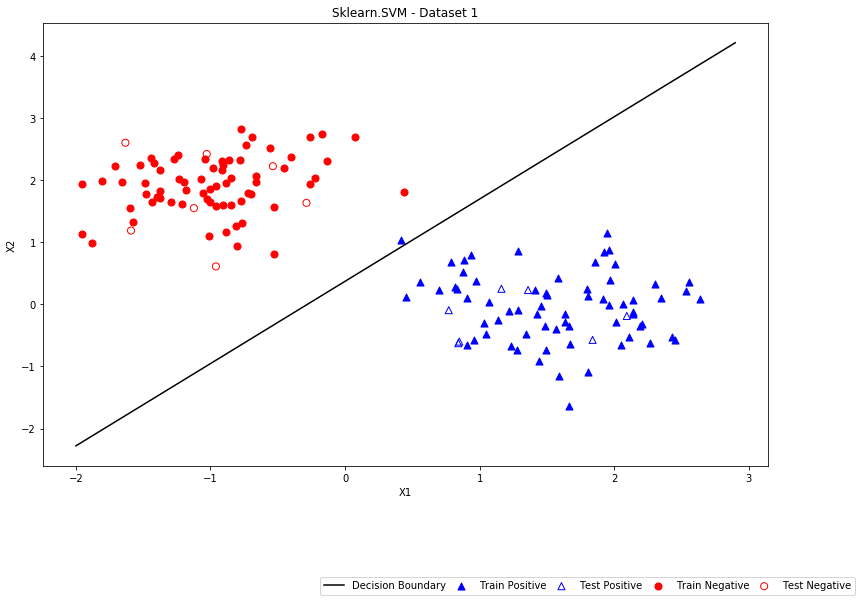

In [22]:
plotSVM(X1_train, y1_train, X1_test, y1_test, clf.coef_, title = "Sklearn.SVM - Dataset 1")

## Classification Error w.r.t 'C' (regularization parameter)

In [23]:
train_err_list = []
test_err_list = []

for c in range(1, 11):
    # Calculate α,b for training data
    alpha, b = smo(X1_train, y1_train, K1, c, tolerance, max_passes)
    
    # Calculate theta
    temp = np.matrix(np.multiply(alpha, y1_train))
    theta_smo = np.dot(temp.T, X1_train)
    theta_smo[0,0] = b
    
    # Mis-classification Error on Training
    y_predict = predict(theta_smo, X1_train) 
    misclassified, err = classificationError(y_predict, y1_train)
    train_err_list.append(err)
    
    # Mis-classification Error on Test
    y_predict = predict(theta_smo, X1_test) 
    misclassified, err = classificationError(y_predict, y1_test)
    test_err_list.append(err)

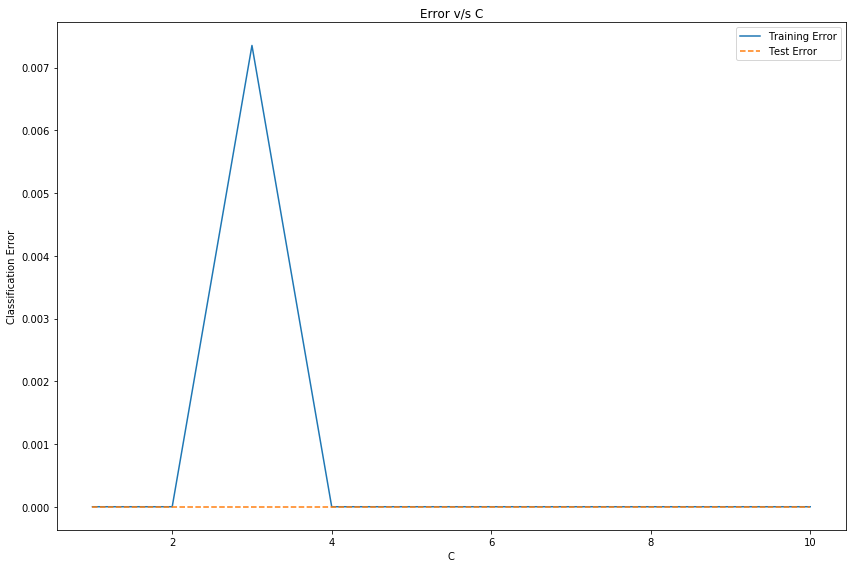

In [24]:
fig, ax = plt.subplots(figsize=(12,8))  

ax.plot(np.arange(1,11), train_err_list, '-', label='Training Error')
ax.plot(np.arange(1,11), test_err_list, '--', label='Test Error')

ax.set_xlabel('C')  
ax.set_ylabel('Classification Error') 
plt.title('Error v/s C')

plt.legend()
fig.tight_layout()

### Dataset 2

In [25]:
dataset2 = sio.loadmat('data2')

In [26]:
X2_train, y2_train = np.matrix(dataset2['X_trn']), np.matrix(dataset2['Y_trn'])
X2_test, y2_test = np.matrix(dataset2['X_tst']), np.matrix(dataset2['Y_tst'])

In [27]:
X2_train = np.hstack((np.ones((X2_train.shape[0], 1)), X2_train))
X2_test = np.hstack((np.ones((X2_test.shape[0], 1)), X2_test))

In [28]:
# Replacing class label 0 with -1
# Mapping y from {0, 1} to {-1, 1}
y2_train = np.where(y2_train==0, -1, 1)
y2_test = np.where(y2_test==0, -1, 1)

In [29]:
# Kernel Matrix
K2 = np.dot(X2_train, X2_train.T)

## 2.a) SMO

In [30]:
c = 1
tolerance = 0.0001
max_passes=1000

In [31]:
alpha, b = smo(X2_train, y2_train, K2, c, tolerance, max_passes)

In [32]:
alpha.shape, b

((126, 1), matrix([[1.64166765]]))

In [33]:
temp = np.matrix(np.multiply(alpha, y2_train))
theta_smo2 = np.dot(temp.T, X2_train)
theta_smo2[0,0] = b

In [34]:
theta_smo2

matrix([[ 1.64166765,  2.29124368, -1.03317943]])

### Classification error on training and test dataset1

In [35]:
y_predict = predict(theta_smo2, X2_train) 
misclassified, err = classificationError(y_predict, y2_train)
print('No of mis-classified Training data points: {0}'.format(misclassified))
print('Classification Error (Training - Dataset 2) = {0:.2f}'.format(err))

No of mis-classified Training data points: 4
Classification Error (Training - Dataset 2) = 0.03


In [36]:
y_predict = predict(theta_smo2, X2_test) 
misclassified, err = classificationError(y_predict, y2_test)
print('No of mis-classified Test data points: {0}'.format(misclassified))
print('Classification Error (Test - Dataset 2) = {0:.2f}'.format(err))

No of mis-classified Test data points: 1
Classification Error (Test - Dataset 2) = 0.07


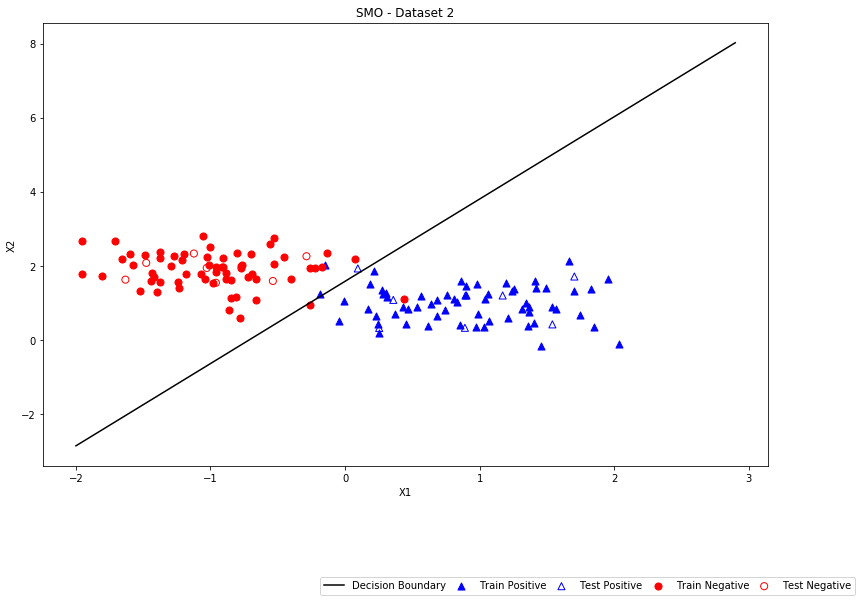

In [37]:
plotSVM(X2_train, y2_train, X2_test, y2_test, theta_smo2, title = "SMO - Dataset 2")

## 2.b) Sklearn Linear SVC

In [38]:
clf = LinearSVC(random_state=0)
clf.fit(X2_train, np.ravel(y2_train))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [39]:
y_predict = predict(clf.coef_, X2_train) 
misclassified, err = classificationError(y_predict, y2_train)
print('No of mis-classified Training data points: {0}'.format(misclassified))
print('Classification Error (Training - Dataset 1) = {0:.2f}'.format(err))

No of mis-classified Training data points: 6
Classification Error (Training - Dataset 1) = 0.05


In [40]:
y_predict = predict(clf.coef_, X2_test) 
misclassified, err = classificationError(y_predict, y2_test)
print('No of mis-classified Test data points: {0}'.format(misclassified))
print('Classification Error (Test - Dataset 1) = {0:.2f}'.format(err))

No of mis-classified Test data points: 1
Classification Error (Test - Dataset 1) = 0.07


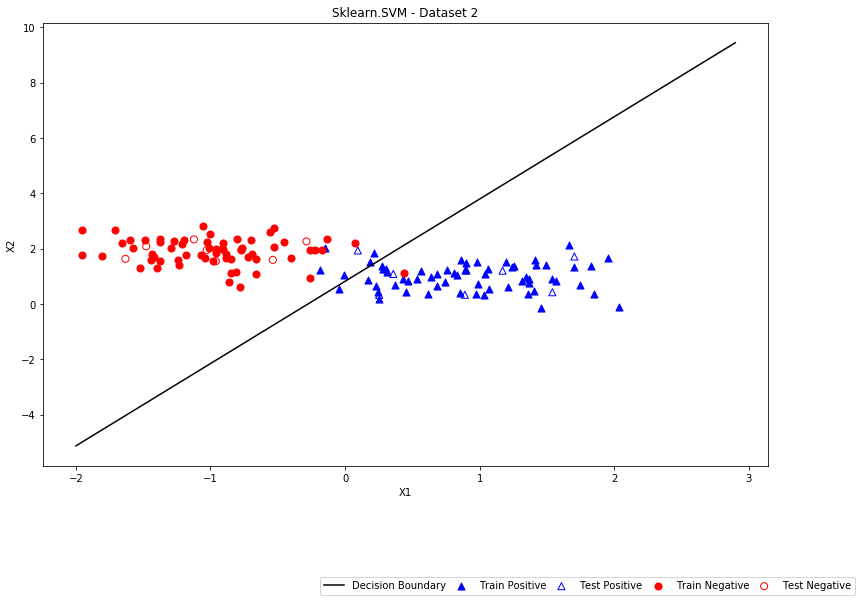

In [41]:
plotSVM(X2_train, y2_train, X2_test, y2_test, clf.coef_, title = "Sklearn.SVM - Dataset 2")

## Classification Error w.r.t 'C' (regularization parameter)

In [42]:
train_err_list = []
test_err_list = []

for c in range(1,51,5):
    # Calculate α,b for training data
    alpha,b = smo(X2_train, y2_train, K2, c, tolerance, max_passes)
    
    # Calculate theta
    temp = np.matrix(np.multiply(alpha,y2_train))
    theta_smo2 = np.dot(temp.T,X2_train)
    theta_smo2[0,0] = b
    
    # Mis-classification Error on Training
    y_predict = predict(theta_smo, X2_train) 
    misclassified, err = classificationError(y_predict, y2_train)
    train_err_list.append(err)
    
    # Mis-classification Error on Test
    y_predict = predict(theta_smo, X2_test) 
    misclassified, err = classificationError(y_predict, y2_test)
    test_err_list.append(err)

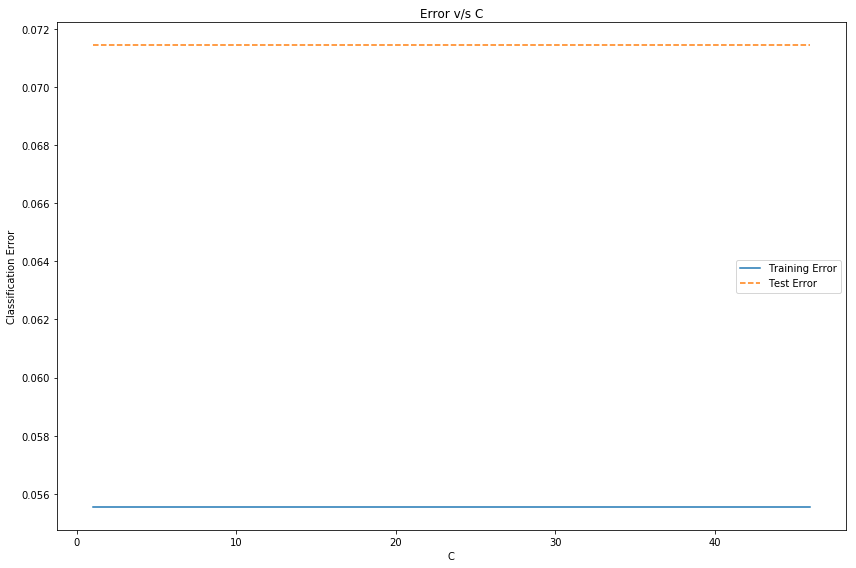

In [43]:
fig, ax = plt.subplots(figsize=(12,8))  

ax.plot(np.arange(1, 51, 5), train_err_list, '-', label='Training Error')
ax.plot(np.arange(1, 51, 5), test_err_list, '--', label='Test Error')


ax.set_xlabel('C')  
ax.set_ylabel('Classification Error') 
plt.title('Error v/s C')

plt.legend()
fig.tight_layout()

Classification error change because of a single Training data point with change in C for Dataset 1, whereas remains the same for both Training and Test data in dataset 2.

Although the Classification error is higher on Dataset 2 in comparison to Dataset 1, it's still a big improvement over classification with Logistic Regression.